#  Segmentation-Based Fractal Texture Analysis (SFTA)

SFTA is a texture-based feature extraction algorithm that depends on two key steps:
  1. Decomposing the input grayscale image into a collection of binary images in which two-threshold binary decomposition is implemented to decompose the data.

  2. Computing SFTA vectors for each binary image generated using the fractal dimension from its region's boundaries, mean gray level, and the number of pixels. 

$$
\varphi_{sfta}(U) =
\begin{cases} 
1 & \text{if } \exists (i', j') \in N_8[(i, j)] : \varphi_e(i', j') = 0 \land \varphi_e(i, j) = 1, \\
0 & \text{Otherwise.}
\end{cases}
$$

Where: $N_8[(i, j)]$ represents the neighborhood of connected pixels (with an 8-connectivity scheme) around the pixel at $(i, j)$ in this work, and $\varphi_{sfta}(U)$ is a binary image.

**Core Intuition of SFTA**

1. Segmentation for Texture Diversity:
    Intuition: Different textures in an image often correspond to distinct intensity ranges or patterns (e.g., smooth vs. rough areas).
    By applying multilevel thresholding, SFTA splits the image into binary regions based on intensity intervals. This segmentation ensures that texture features are extracted separately for distinct intensity-based regions.

2. Fractal Dimension for Texture Complexity:
    Intuition: Many natural textures (e.g., leaves, terrain, or clouds) exhibit self-similarity and can be analyzed using fractal geometry.
    The fractal dimension quantifies the complexity of texture patterns within each binary region, providing a robust measure of how detailed or rough a texture is.

3. 8-Connectivity to Isolate Regions:
    Intuition: Textures are not only defined by their intensity but also by the spatial connectivity of pixels.
    SFTA uses 8-connectivity to identify individual regions within each binary image, treating each connected component as a distinct texture feature.

4. Complementary Binary Images for Coverage:
    Intuition: Certain regions in an image might not be captured directly in the binary segmentation (e.g., transitional or boundary regions between textures).
    By generating complementary binary images, SFTA ensures that all areas of the image are analyzed, reducing the risk of missing important texture details.

5. Feature Vector for Classification:
    Intuition: Texture properties can be represented as numerical values that are useful for tasks like classification, clustering, or recognition.
    SFTA combines fractal dimensions and region sizes from all binary and complementary images into a feature vector. This vector becomes a compact representation of the image’s texture.

In [2]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
from skimage.measure import label

**Step1 : Input Grayscale Image**

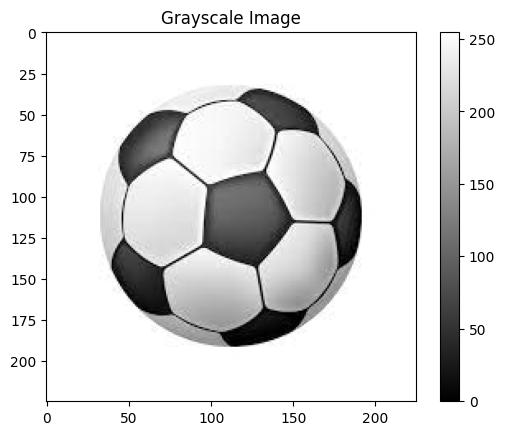

In [3]:
gray_img = cv2.imread('ball.jpg', cv2.IMREAD_GRAYSCALE)

plt.imshow(gray_img, cmap='gray')
plt.title('Grayscale Image')
plt.colorbar()
plt.show()

**Step2 : Define the thresholds and calculate intervals**

In [4]:
# Define thresholds
thresholds = [50, 100, 150]

# Function to generate binary images for each interval
def threshold_binary_images(image, thresholds):
    thresholds = sorted(thresholds)
    binary_images = []
    ranges = [(None, thresholds[0])]  # Pixels < T1
    ranges += [(thresholds[i], thresholds[i+1]) for i in range(len(thresholds)-1)]  # Pixels between thresholds
    ranges.append((thresholds[-1], None))  # Pixels >= T3

    for r in ranges:
        if r[0] is None:  # Below the first threshold
            binary_images.append((image < r[1]).astype(np.uint8))
        elif r[1] is None:  # Above the last threshold
            binary_images.append((image >= r[0]).astype(np.uint8))
        else:  # Between thresholds
            binary_images.append(((image >= r[0]) & (image < r[1])).astype(np.uint8))
    
    return binary_images

# Generate binary images
binary_images = threshold_binary_images(gray_img, thresholds)

print(f'The number of binary images : {len(binary_images)}')


The number of binary images : 4


**Step3 : Display the binary images generated by the thresholds.**

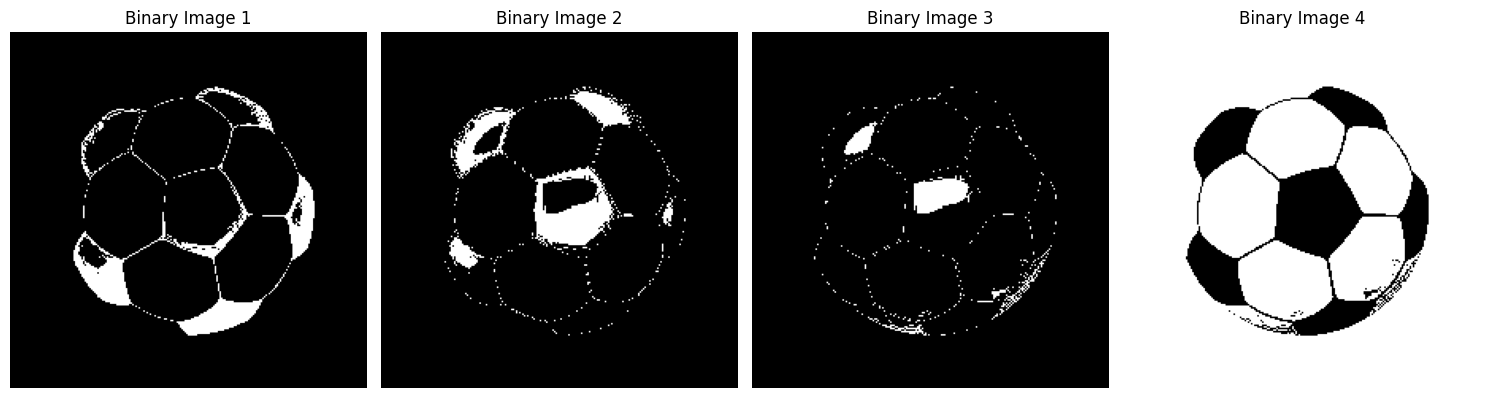

In [5]:
# Create a figure with one row and as many columns as there are images
fig, axes = plt.subplots(1, len(binary_images), figsize=(15, 5))  # Adjust `figsize` as needed

for i, (binary_image, ax) in enumerate(zip(binary_images, axes)):
    ax.imshow(binary_image, cmap='gray')
    ax.set_title(f"Binary Image {i+1}")
    ax.axis('off')  # Remove axis for better visualization

plt.tight_layout()  # Adjust layout to avoid overlap
plt.show()

**Step4 : Use 8-connectivity to label connected components in each binary image.**

In [6]:
def find_connected_components(binary_images):
    connected_components = []
    for binary_image in binary_images:
        # Label connected components (8-connectivity)
        labeled_image, num_labels = label(binary_image, connectivity=2, return_num=True)
        connected_components.append((labeled_image, num_labels))
    return connected_components

# Find connected components
connected_components = find_connected_components(binary_images)

print(f'The number of connected components : {len(connected_components)}')

The number of connected components : 4


**Step5 : Subtract the largest connected region from the binary image to create complementary images.**

In [7]:
def generate_complementary_images(binary_images, connected_components):
    complementary_images = []
    for binary_image, (labeled_image, num_labels) in zip(binary_images, connected_components):
        # Find the largest connected region
        sizes = [np.sum(labeled_image == i) for i in range(1, num_labels + 1)]
        largest_region = (labeled_image == (np.argmax(sizes) + 1)).astype(np.uint8)

        # Generate complementary image
        complementary_image = binary_image - largest_region
        complementary_images.append(complementary_image)
    return complementary_images

# Generate complementary images
complementary_images = generate_complementary_images(binary_images, connected_components)

print(f'The number of complementary images : {len(complementary_images)}')

The number of complementary images : 4


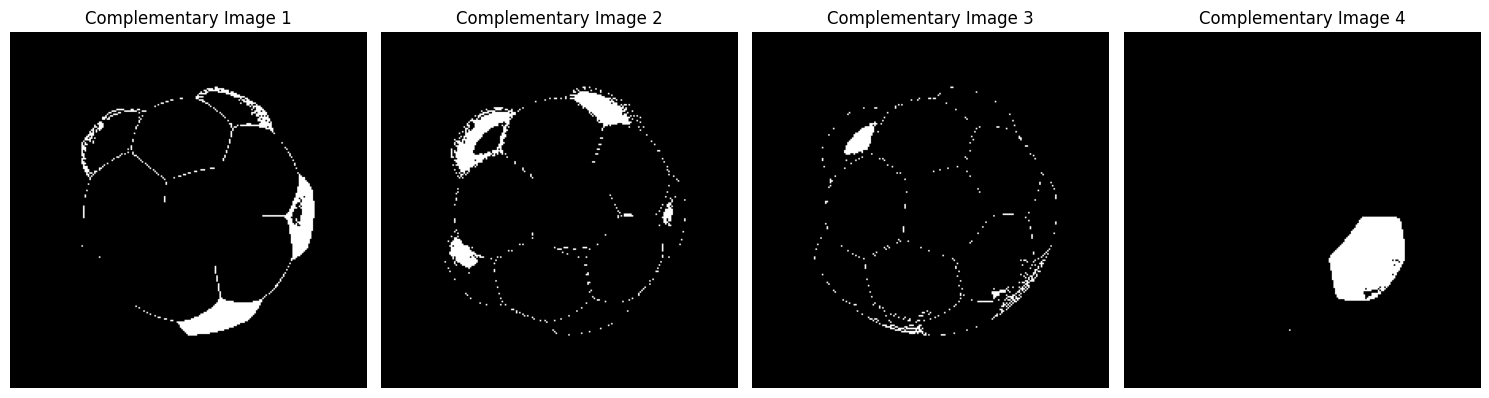

In [8]:
# Create a figure with one row and as many columns as there are images
fig, axes = plt.subplots(1, len(complementary_images), figsize=(15, 5))  # Adjust `figsize` as needed

for i, (complementary_images, ax) in enumerate(zip(complementary_images, axes)):
    ax.imshow(complementary_images, cmap='gray')
    ax.set_title(f"Complementary Image {i+1}")
    ax.axis('off')  # Remove axis for better visualization

plt.tight_layout()  # Adjust layout to avoid overlap
plt.show()

**Step7 : Fractal Dimension Calculation.**

In [9]:
def fractal_dimension(binary_image):
    """
    Compute the fractal dimension of a binary image using the box-counting method.
    """
    def box_count(image, box_size):
        step = box_size
        count = 0
        for i in range(0, image.shape[0], step):
            for j in range(0, image.shape[1], step):
                if np.any(image[i:i+step, j:j+step]):
                    count += 1
        return count

    # Define box sizes
    sizes = [2**i for i in range(1, int(np.log2(min(binary_image.shape))) + 1)]
    counts = [box_count(binary_image, size) for size in sizes]

    # Fit a line to log-log plot and compute slope (fractal dimension)
    coeffs = np.polyfit(np.log(sizes), np.log(counts), 1)
    return -coeffs[0]

**Step8 : Feature Extraction**

In [10]:
def extract_features(binary_images, complementary_images):
    """
    Extract SFTA features (fractal dimensions and region sizes) from binary and complementary images.
    """
    feature_vector = []

    all_images = binary_images + complementary_images

    for binary_image in all_images:
        # Label connected regions
        labeled_image, num_labels = label(binary_image, connectivity=2, return_num=True)

        for region_label in range(1, num_labels + 1):
            # Extract each connected region
            region = (labeled_image == region_label).astype(np.uint8)

            # Compute fractal dimension
            fd = fractal_dimension(region)

            # Compute region size
            size = np.sum(region)

            # Append features to feature vector
            feature_vector.extend([fd, size])

    return feature_vector

# Extract features
features = extract_features(binary_images, complementary_images)
print("Feature Vector:", len(features))


Feature Vector: 800


In [11]:
import numpy as np

def mean_grayscale_level(image, mask):
    """
    Calculates the mean grayscale level for a given image and mask.

    Parameters:
        image (numpy.ndarray): Grayscale image (2D array).
        mask (numpy.ndarray): Binary mask (2D array) of the same size as the image, 
                              where non-zero values indicate the region of interest.

    Returns:
        float: Mean grayscale level of the region specified by the mask.
    """
    if image.shape != mask.shape:
        raise ValueError("Image and mask must have the same dimensions.")

    # Extract pixel values from the image where the mask is non-zero
    region_pixels = image[mask > 0]

    # Calculate the mean grayscale level
    mean_gray = np.mean(region_pixels) if region_pixels.size > 0 else 0

    return mean_gray

# Example usage
if __name__ == "__main__":
    # Example grayscale image (5x5)
    image = np.array([
        [10, 20, 30, 40, 50],
        [15, 25, 35, 45, 55],
        [20, 30, 40, 50, 60],
        [25, 35, 45, 55, 65],
        [30, 40, 50, 60, 70]
    ], dtype=np.uint8)

    # Example binary mask (5x5)
    mask = np.array([
        [0, 1, 1, 0, 0],
        [0, 1, 1, 0, 0],
        [0, 0, 1, 1, 0],
        [0, 0, 1, 1, 0],
        [0, 0, 0, 1, 1]
    ], dtype=np.uint8)

    mean_gray_level = mean_grayscale_level(image, mask)
    print("Mean Grayscale Level:", mean_gray_level)

Mean Grayscale Level: 43.0


Number of Connected Components: 3


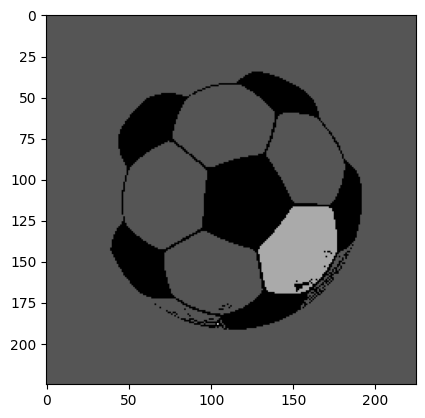

In [17]:
import numpy as np

def connected_component_labeling(binary_image):
    # Initialize variables
    labeled_image = np.zeros_like(binary_image, dtype=int)  # Output image for labels
    current_label = 1  # Start labeling from 1
    rows, cols = binary_image.shape

    # Define 8-connectivity neighbors
    neighbors = [(-1, -1), (-1, 0), (-1, 1),  # Top-left, Top, Top-right
                 (0, -1),          (0, 1),   # Left,       Right
                 (1, -1), (1, 0), (1, 1)]   # Bottom-left, Bottom, Bottom-right

    def flood_fill(x, y, label):
        """
        Flood-fill algorithm to label a connected component.
        """
        stack = [(x, y)]  # Use a stack to implement iterative DFS
        while stack:
            cx, cy = stack.pop()
            if labeled_image[cx, cy] == 0 and binary_image[cx, cy] == 1:
                labeled_image[cx, cy] = label
                # Add all 8-connected neighbors to the stack
                for dx, dy in neighbors:
                    nx, ny = cx + dx, cy + dy
                    if 0 <= nx < rows and 0 <= ny < cols:  # Check bounds
                        stack.append((nx, ny))

    # Iterate through the binary image to find connected components
    for i in range(rows):
        for j in range(cols):
            if binary_image[i, j] == 1 and labeled_image[i, j] == 0:
                # Start a new connected component
                flood_fill(i, j, current_label)
                current_label += 1

    # Return the labeled image and the number of labels
    return labeled_image, current_label - 1


labeled_image, num_labels = connected_component_labeling(binary_image)

print(f"Number of Connected Components: {num_labels}")


plt.imshow(labeled_image, cmap='gray')
plt.show()